In [2]:
import jax.numpy as jnp
from jax import grad, jit
import MDAnalysis as mda
import matplotlib.pyplot as plt

/Users/sss/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Topology :  
What Property of an Objevt stays the same as you change the shape of that object?

### Protein backbone, C alpha

In [3]:
# Load trajectory and topology
xtc_file = "/Users/sss/Documents/EnergyGap_project/rc_example/md.xtc"
tpr_file = "/Users/sss/Documents/EnergyGap_project/ENG_cv_codes/md.tpr"


u = mda.Universe(tpr_file, xtc_file)
u.trajectory[70] #select frame index
ca_atoms = u.select_atoms("name CA") #protein backbone

positions_protein = ca_atoms.positions
positions_protein.shape
print(len(positions_protein))

20


# shapes

In [4]:
#Trefoil Knot
t = jnp.linspace(0, 2 * jnp.pi, 100)
x = jnp.sin(t) + 2 * jnp.sin(2 * t)
y = jnp.cos(t) - 2 * jnp.cos(2 * t)
z = -jnp.sin(3 * t)

positions_trefoil = jnp.vstack([x, y, z]).T


t = jnp.linspace(0, 6 * jnp.pi, 50)  # Parameter for a sine wave-like curve
# positions = jnp.array([
#     [t_i, jnp.sin(t_i), 0] for t_i in t  # all curve points are on the xy plane.
# ])
positions_helix = jnp.array([
    [jnp.cos(t_i), jnp.sin(t_i), t_i] for t_i in t  # Helical curve

])

### Construct the line segments using finite differences approximation

In [5]:
tangents = jnp.diff(positions_trefoil, axis=0)
tangents_norm = jnp.linalg.norm(tangents, axis=1, keepdims=True)
segments = tangents / tangents_norm

segments.shape

(99, 3)

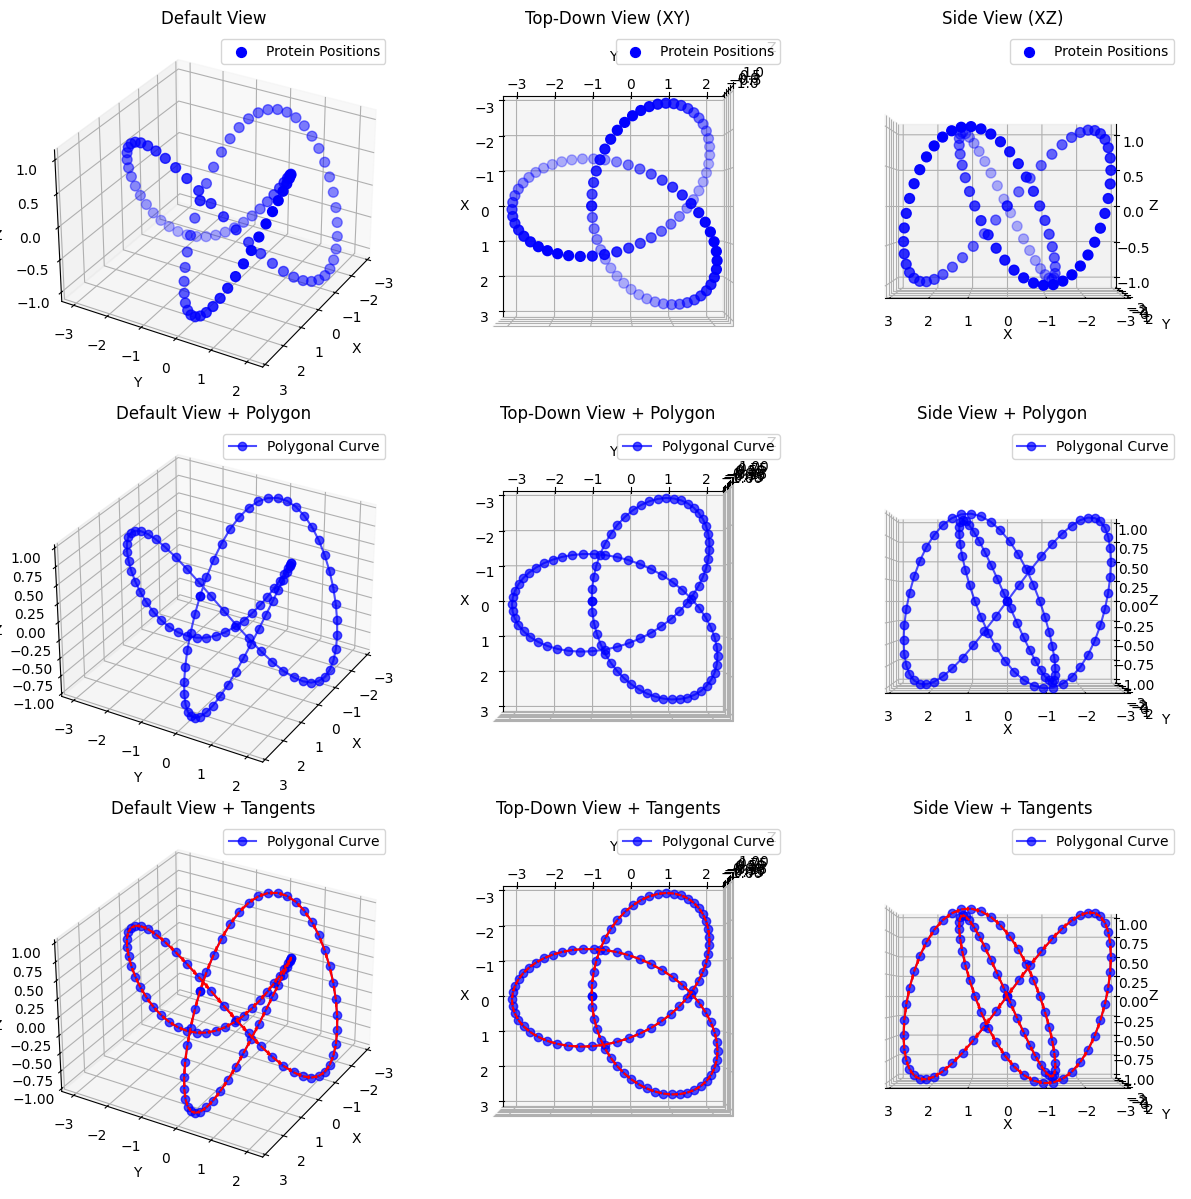

In [6]:
fig = plt.figure(figsize=(12, 12))  


view_angles = [(30, 30), (90, 0), (0, 90)]  # (elevation, azimuth)
titles_positions = ["Default View", "Top-Down View (XY)", "Side View (XZ)"]
titles_curve = ["Default View + Polygon", "Top-Down View + Polygon", "Side View + Polygon"]
titles_tangents = ["Default View + Tangents", "Top-Down View + Tangents", "Side View + Tangents"]

# Only Positions 
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 1, projection='3d')

    ax.scatter(positions_trefoil[:, 0], positions_trefoil[:, 1], positions_trefoil[:, 2], 
               color='blue', s=50, label="Protein Positions")

    # Set viewing angle
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_positions[i])
    ax.legend()

# Polygonal Curve (Line Plot)
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 4, projection='3d')

    # Plot Polygonal Curve (Backbone connectivity)
    ax.plot(positions_trefoil[:, 0], positions_trefoil[:, 1], positions_trefoil[:, 2], 
            'bo-', alpha=0.7, label="Polygonal Curve")

    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_curve[i])
    ax.legend()

# Polygonal Curve + Tangents (Quiver plot)
for i, (elev, azim) in enumerate(view_angles):
    ax = fig.add_subplot(3, 3, i + 7, projection='3d')

    
    ax.plot(positions_trefoil[:, 0], positions_trefoil[:, 1], positions_trefoil[:, 2], 
            'bo-', alpha=0.7, label="Polygonal Curve")

    # Plot Tangent Vectors
    for j in range(len(tangents)):
        ax.quiver(positions_trefoil[j, 0], positions_trefoil[j, 1], positions_trefoil[j, 2],  
                  tangents[j, 0], tangents[j, 1], tangents[j, 2], 
                  color='red', length=0.8, arrow_length_ratio=0.3, normalize=False)


    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(titles_tangents[i])
    ax.legend()

plt.tight_layout()
plt.show()


# Writhe Function  

The writhe function is a mathematical measure of the self-entanglement of a curve in 3D space. It originates from the Gauss linking integral, which computes the topological linking between two curves.  
In the case of a single curve, the writhe describes how much the curve twists around itself.


$$
Wr(C) = \frac{1}{4\pi} \int_C \int_C \frac{(\dot{\gamma}(s) \times \dot{\gamma}(t)) \cdot (\gamma(s) - \gamma(t))}{|\gamma(s) - \gamma(t)|^3} \, ds \, dt
$$

where:  
$\gamma(ti)$ is the parameterized curve.  
$ \dot{\gamma}(ti) $ is the tangent vector.  
$\ (\dot{\gamma}(ti) \times \dot{\gamma}(tj)) $ is the **cross product** of tangents.  
$\ (\gamma(ti) - \gamma(tj)|^3 )$ normalizes the integral.



## **Kernel Function: Scalar Triple Product**
The scalar triple product is the core mathematical operation, which encodes the geometric twisting between two segments of the curve:

$$
K(i, j) = \frac{t_i \cdot (t_j \times (r_i - r_j))}{|r_i - r_j|^3}
$$

where:  

$t_i$ and $t_j$ are tangent vectors.  
$r_i$, $r_j$ are points on the curve. 





## **2-Simplex Restriction**
Instead of computing over all possible point pairs, the 2-simplex restriction was nused to consider segments rather than individual points.

The indices are restricted to ensure $i > j$, preventing redundant calculations.


Mathematically, this is done by setting a triangular matrix:

$$
i, j = \text{triu\_indices}(N - 1, k=1)
$$


## **Final Computation of the Writhe**
The final **writhe sum** is computed as:

$$
Wr = \frac{1}{2\pi} \sum_{i > j} \frac{t_i \cdot (t_j \times (r_i - r_j))}{|r_i - r_j|^3}
$$

where the **sum runs over all distinct segment pairs**.


In [11]:
def compute_writhe(positions):   
    N = len(positions)
    tangents = jnp.diff(positions, axis=0)
    tangents /= jnp.linalg.norm(tangents, axis=1, keepdims=True)  # Normalize

    writhe_sum = 0.0

    # Loop over all segment pairs
    for i1 in range(N - 1):
        for i2 in range(i1 + 1, N - 1):
            diff = positions[i1] - positions[i2]
            cross_prod = jnp.cross(tangents[i2], diff)
            scalar_triple_product = jnp.dot(tangents[i1], cross_prod)
            distance_cubed = jnp.linalg.norm(diff) ** 3

            #if distance_cubed != 0:
            writhe_sum += scalar_triple_product / distance_cubed

    writhe = (1.0 / (2.0 * jnp.pi)) * writhe_sum
    return writhe

# # Compute writhe for the Trefoil Knot
# writhe_value = compute_writhe(positions)

print(f"writhe is: {compute_writhe(positions_trefoil)}")
# %timeit compute_writhe(positions_trefoil)
# %timeit writhe_grade(positions_trefoil)


# print(f"Computed Writhe: {writhe_value:.6f}")
writhe_grade =grad(compute_writhe)(positions_trefoil)
print(writhe_grade)

writhe is: -31.215133666992188
[[-2.05908656e+00 -4.58651260e-02 -3.47788191e+00]
 [ 1.04906298e-01 -3.24388653e-01 -3.74722183e-01]
 [ 3.95236164e-01 -3.04449588e-01 -4.84138906e-01]
 [ 6.48333430e-01 -1.74635172e-01 -4.93362308e-01]
 [ 7.20503628e-01 -4.37254608e-02 -4.38273966e-01]
 [ 6.59989059e-01  1.42316520e-02 -3.66438180e-01]
 [ 5.79161048e-01  1.98991895e-02 -2.88411647e-01]
 [ 5.21950483e-01  1.49460435e-02 -2.04006523e-01]
 [ 4.72134590e-01  2.80250013e-02 -1.18217111e-01]
 [ 3.91697854e-01  6.93572760e-02 -4.58279550e-02]
 [ 2.63014317e-01  1.24415100e-01 -4.59832512e-03]
 [ 1.14966668e-01  1.62018329e-01  2.67985463e-03]
 [-2.03859806e-03  1.61825076e-01 -7.54860044e-03]
 [-6.27974421e-02  1.29865348e-01 -1.69875026e-02]
 [-7.69309849e-02  8.56629163e-02 -1.87821984e-02]
 [-6.63660020e-02  4.38660383e-02 -1.45912766e-02]
 [-4.70258296e-02  8.69807974e-03 -7.53639638e-03]
 [-2.48542279e-02 -2.20857561e-02  6.64077699e-04]
 [ 1.45275146e-03 -5.16451001e-02  9.69578326e-03]


In [8]:
# positions[2]

In [9]:
@jit
def compute_writhe_simplex(positions:float)->float:
    """
    Compute the writhe of a protein backbone using the 2-simplex formulation.

    Parameters:
        positions: jnp.array of shape (N, 3), where N is the number of residues.
        
    Returns:
        Writhe value (scalar)
    """
    N = positions.shape[0]

    # Compute tangent vectors (finite difference approximation)
    tangents = jnp.diff(positions, axis=0)
    tangents /= jnp.linalg.norm(tangents, axis=1, keepdims=True)  # Normalize

    # Generate all index pairs (i, j) with i > j (strictly upper triangular part)
    i_idx, j_idx = jnp.triu_indices(N - 1, k=1)  # k=1 ensures i > j

    # Extract relevant points and tangents
    r_i, r_j = positions[i_idx], positions[j_idx]
    t_i, t_j = tangents[i_idx], tangents[j_idx]

    # Compute pairwise displacement vectors
    diff = r_i - r_j  # Shape: (M, 3)

    # Compute cross product t_j x (r_i - r_j)
    cross_prod = jnp.cross(t_j, diff)  # Shape: (M, 3)

    # Compute scalar triple product: t_i ⋅ (t_j × (r_i - r_j))
    scalar_triple_product = jnp.einsum("ij,ij->i", t_i, cross_prod)
    # scalar_triple_product = jnp.dot(t_i, cross_prod)

# t_i.shape = (N-1, N-1, 3)  # (i, j, k)
# cross_prod.shape = (N-1, N-1, 3)  # (i, j, k)

# First axis (i): Iterates over the first segment.
# Second axis (j): Iterates over the second segment.
# Third axis (k) (the "last axis"): Represents the three spatial coordinates (x, y, z).
# So for each pair of segments (i, j), we have a 3D vector 
# (x,y,z).


    distance_cubed = jnp.linalg.norm(diff, axis=1) ** 3
    distance_cubed = jnp.where(distance_cubed == 0, jnp.inf, distance_cubed)  # Avoid division by zero

    # Compute writhe sum witht he restriction.
    writhe_sum = jnp.sum(scalar_triple_product / distance_cubed)

    # Finall, with the normalization factor
    writhe = (1 / (2 * jnp.pi)) * writhe_sum  # Factor adjusted for simplex

    return writhe



writhe_grade = jit(grad(compute_writhe_simplex))
print(f"writhe is: {compute_writhe_simplex(positions_trefoil)}, grad is: {writhe_grade(positions_trefoil)}")

%timeit compute_writhe_simplex(positions_trefoil)
%timeit writhe_grade(positions_trefoil)

writhe is: -31.215160369873047, grad is: [[-2.05908585e+00 -4.58648950e-02 -3.47788167e+00]
 [ 1.04906388e-01 -3.24389011e-01 -3.74721944e-01]
 [ 3.95235360e-01 -3.04449558e-01 -4.84140158e-01]
 [ 6.48333549e-01 -1.74634606e-01 -4.93362367e-01]
 [ 7.20503926e-01 -4.37257290e-02 -4.38273430e-01]
 [ 6.59989417e-01  1.42316222e-02 -3.66437286e-01]
 [ 5.79160213e-01  1.98997259e-02 -2.88412035e-01]
 [ 5.21951199e-01  1.49445534e-02 -2.04008341e-01]
 [ 4.72134233e-01  2.80264616e-02 -1.18215561e-01]
 [ 3.91697884e-01  6.93567991e-02 -4.58272696e-02]
 [ 2.63013840e-01  1.24414802e-01 -4.59778309e-03]
 [ 1.14967346e-01  1.62018538e-01  2.67767906e-03]
 [-2.03883648e-03  1.61824942e-01 -7.54678249e-03]
 [-6.27969503e-02  1.29864812e-01 -1.69880390e-02]
 [-7.69323707e-02  8.56634378e-02 -1.87821388e-02]
 [-6.63653612e-02  4.38659191e-02 -1.45910978e-02]
 [-4.70255017e-02  8.69739056e-03 -7.53629208e-03]
 [-2.48538852e-02 -2.20865011e-02  6.63876534e-04]
 [ 1.45345926e-03 -5.16443253e-02  9.6955

# Higher-order topological invariant   
### These measures are inspired by the formulas for the **Vassiliev knot**
### This function extends the writhe computation above to capturing triplet-based entanglements rather than just pairwise crossings.

In [10]:
from itertools import combinations

def compute_higher_order_I(positions):
    N = len(positions)

    tangents = jnp.diff(positions, axis=0)
    tangents /= jnp.linalg.norm(tangents, axis=1, keepdims=True)


    # Generate distinct triplets for (i1, i2, i3) from the first half of the protein
    triplets_1 = jnp.array(list(combinations(range(N // 2), 3)))  # First half

    # Generate distinct triplets for (i4, i5, i6) from the second half of the protein
    triplets_2 = jnp.array(list(combinations(range(N // 2, N + 1), 3)))  # Second half


    min_triplets = min(triplets_1.shape[0], triplets_2.shape[0])

    # Trim to ensure they have the same shape
    triplets_1 = triplets_1[:min_triplets]
    triplets_2 = triplets_2[:min_triplets]

    # Extract indices
    i1, i2, i3 = triplets_1[:, 0], triplets_1[:, 1], triplets_1[:, 2]
    i4, i5, i6 = triplets_2[:, 0], triplets_2[:, 1], triplets_2[:, 2]



    # Compute displacement vectors
    diff_15 = positions[i1] - positions[i5]
    diff_24 = positions[i2] - positions[i4]
    diff_36 = positions[i3] - positions[i6]

    # Compute cross products
    cross_15 = jnp.cross(tangents[i1], diff_15)
    cross_24 = jnp.cross(tangents[i2], diff_24)
    cross_36 = jnp.cross(tangents[i3], diff_36)

    # Compute norms for normalization
    norm_15 = jnp.linalg.norm(diff_15, axis=1) ** 3
    norm_24 = jnp.linalg.norm(diff_24, axis=1) ** 3
    norm_36 = jnp.linalg.norm(diff_36, axis=1) ** 3

    # Compute kernel functions
    kernel_15 = jnp.einsum("ij,ij->i", cross_15, diff_15) / norm_15
    kernel_24 = jnp.einsum("ij,ij->i", cross_24, diff_24) / norm_24
    kernel_36 = jnp.einsum("ij,ij->i", cross_36, diff_36) / norm_36

    # kernel_15 = jnp.dot(cross_15, diff_15) / norm_15
    # kernel_24 = jnp.dot(cross_24, diff_24) / norm_24
    # kernel_36 = jnp.dot(cross_36, diff_36) / norm_36

    # Compute the higher-order invariant sum
    I_value = jnp.sum(kernel_15 * kernel_24 * kernel_36) / (3 * jnp.pi)

    return I_value

# JIT compilation
compute_higher_order_I_jit = jit(compute_higher_order_I)



#I_value = compute_higher_order_I(positions)
I_value_jitted = compute_higher_order_I_jit(positions_trefoil)


grad_I = jit(grad(compute_higher_order_I))(positions_trefoil)

print(f"Computed Higher-Order I: {I_value_jitted:.10f},")
print(f"Computed Higher-Order I grad: {grad_I}")

Computed Higher-Order I: -0.0000000000,
Computed Higher-Order I grad: [[ 1.0255961e-24  1.2143215e-24  1.4502900e-24]
 [-6.8781763e-25 -5.4072956e-24 -3.0506097e-24]
 [-2.1181574e-24  3.3359524e-24 -3.3898300e-24]
 [ 1.0664334e-25 -1.2102596e-24 -1.1730026e-24]
 [ 2.5622833e-24 -1.5853182e-24  5.4537859e-24]
 [ 1.0201354e-24 -1.8344523e-24  1.5826475e-24]
 [-2.8663949e-24  2.1077042e-24 -4.1393173e-24]
 [ 6.7419701e-25  2.0133505e-26  3.2999706e-24]
 [-2.1421197e-25 -1.5562106e-25  7.6402717e-25]
 [ 6.3657722e-26 -1.3206315e-25 -2.8115870e-24]
 [ 1.7693712e-24  2.2155099e-25  4.8677747e-26]
 [-8.7149241e-25 -4.8162305e-25  1.8191259e-24]
 [ 1.9869288e-24  8.6420422e-25 -1.3093722e-24]
 [ 2.6235364e-24  1.2600778e-24 -3.6019310e-25]
 [-1.7971577e-24 -8.7439581e-25  1.2144882e-24]
 [ 1.3689786e-25  1.1847779e-25  6.2025185e-25]
 [-9.3156259e-25  2.0603083e-24 -9.5672104e-25]
 [ 5.3246829e-25 -6.4677798e-25  4.5385406e-25]
 [-1.3908209e-24  2.0426492e-24 -2.1195209e-24]
 [ 1.5806568e-24 -